# Load file

In [1]:
import numpy as np
import sklearn as sk
import pandas as pd
from time import time
import matplotlib.pyplot as plt
from sklearn import metrics
import gc
import time

from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc, roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import classification_report

import seaborn as sns
from pylab import rcParams
import pickle
from sklearn import metrics
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

from pyod.utils.example import visualize
import warnings
import matplotlib.font_manager
warnings.filterwarnings("ignore")

In [2]:
df_path = "C:/Users/Enduser/OneDrive - Asia Pacific University/uni/Y3S2/fyp/Model_trial/btc_trial_dataset2.csv"
dataset_df = pd.read_csv(df_path)

# Drop

In [3]:
drop_cols = ['tx_hash', 'is_malicious', 'all_malicious', 'mean_in_btc', 'mean_out_btc']
dataset_df.drop(columns=drop_cols, inplace=True)

In [4]:
dataset_df.head()

,indegree,outdegree,in_btc,out_btc,total_btc,in_malicious,out_malicious,out_and_tx_malicious
0,4,2,0.478187,0.476987,0.955174,0,0,0
1,3,2,2.019000,2.018500,4.037500,0,0,0
2,1,1,0.180100,0.180100,0.360200,0,0,0
3,1,2,5.879800,5.879300,11.759100,0,0,0
4,4,2,0.495906,0.495406,0.991312,0,0,0


# Data Splitting

In [ ]:
from sklearn.model_selection import train_test_split

X = dataset_df.drop('out_and_tx_malicious', axis=1)
y = dataset_df['out_and_tx_malicious']

# Original dataset split into train (80%) and test (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,stratify=y, random_state=42)

# further split the training data into train (85%) and validation (15%)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.10, random_state=42)

print("Data Split Complete:")
print(f"Train Size: {X_train.shape[0]}")
print(f"Validation Size: {X_val.shape[0]}")
print(f"Test Size: {X_test.shape[0]}")


# log

In [6]:
X_train_log = X_train.copy()
X_val_log = X_val.copy()
X_test_log = X_test.copy()

log_features = ['indegree', 'outdegree', 'in_btc', 'out_btc','total_btc']

for feature in log_features:
    X_train_log[feature] = np.log1p(X_train_log[feature])  # log1p avoids log(0)
    X_val_log[feature] = np.log1p(X_val_log[feature])
    X_test_log[feature] = np.log1p(X_test_log[feature])

# # Histogram Visualization
# histogram_plot(X_train_log, log_features)


# Data balancing -smote

In [7]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE after log transformation
smote = SMOTE(sampling_strategy=0.01, random_state=42)  
X_train_smote, y_train_smote = smote.fit_resample(X_train_log, y_train)

print("Class distribution after SMOTE:")
print(pd.Series(y_train_smote).value_counts())


Class distribution after SMOTE:
out_and_tx_malicious
0    71922
1      719
Name: count, dtype: int64


# Robust scale

In [8]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train_smote)  # Fit only on train set
X_val_scaled = scaler.transform(X_val_log)  # Transform using the same scaler
X_test_scaled = scaler.transform(X_test_log)

# Convert back to DataFrame
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_val_scaled_df = pd.DataFrame(X_val_scaled, columns=X_val.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns)

# Check data distribution
print("Training Data Distribution After Robust Scaling:")
print(X_train_scaled_df.describe())

# # Histogram Visualization
# histogram_plot(X_train_scaled_df, X_train_scaled_df.columns)


Training Data Distribution After Robust Scaling:
           indegree     outdegree        in_btc       out_btc     total_btc  \
count  72641.000000  72641.000000  72641.000000  72641.000000  72641.000000   
mean       0.631314     -0.026729      0.317750      0.311137      0.235911   
std        1.172266      0.262061      0.744837      0.728930      0.659368   
min       -1.709511     -1.098612     -0.301512     -0.301201     -0.387967   
25%        0.000000      0.000000     -0.258332     -0.259148     -0.320291   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        1.000000      0.000000      0.741668      0.740852      0.679709   
max       14.167938      5.493061      5.320361      5.193626      4.253068   

       in_malicious  out_malicious  
count  72641.000000   72641.000000  
mean       0.000165       0.004020  
std        0.012852       0.063275  
min        0.000000       0.000000  
25%        0.000000       0.000000  
50%        0.0000

# Model Building

[I 2025-03-28 16:05:44,476] A new study created in memory with name: no-name-b324abef-2920-43f7-a162-c919299aaedd
[I 2025-03-28 16:05:44,949] Trial 0 finished with value: 0.01790073230268511 and parameters: {'max_depth': 5, 'learning_rate': 0.016003241262208933, 'n_estimators': 158, 'subsample': 0.7004225259711787, 'min_child_weight': 6, 'reg_alpha': 0.6223462348084495, 'reg_lambda': 5.139699595575109, 'colsample_bytree': 0.9120025509616065}. Best is trial 0 with value: 0.01790073230268511.
[I 2025-03-28 16:05:45,264] Trial 1 finished with value: 0.011091504915553314 and parameters: {'max_depth': 3, 'learning_rate': 0.023413104547776745, 'n_estimators': 139, 'subsample': 0.9865938103396252, 'min_child_weight': 9, 'reg_alpha': 0.0021356167388912888, 'reg_lambda': 0.0012685446858291198, 'colsample_bytree': 0.7116360736116571}. Best is trial 0 with value: 0.01790073230268511.
[I 2025-03-28 16:05:45,720] Trial 2 finished with value: 0.0021975826590750177 and parameters: {'max_depth': 6, 'l

Best Parameters: {'max_depth': 6, 'learning_rate': 0.06387471944064921, 'n_estimators': 462, 'subsample': 0.6103230975393565, 'min_child_weight': 1, 'reg_alpha': 0.05058729198073988, 'reg_lambda': 0.0016393050304642828, 'colsample_bytree': 0.9123490158913169}
Optimal Threshold from Full Training: 0.931


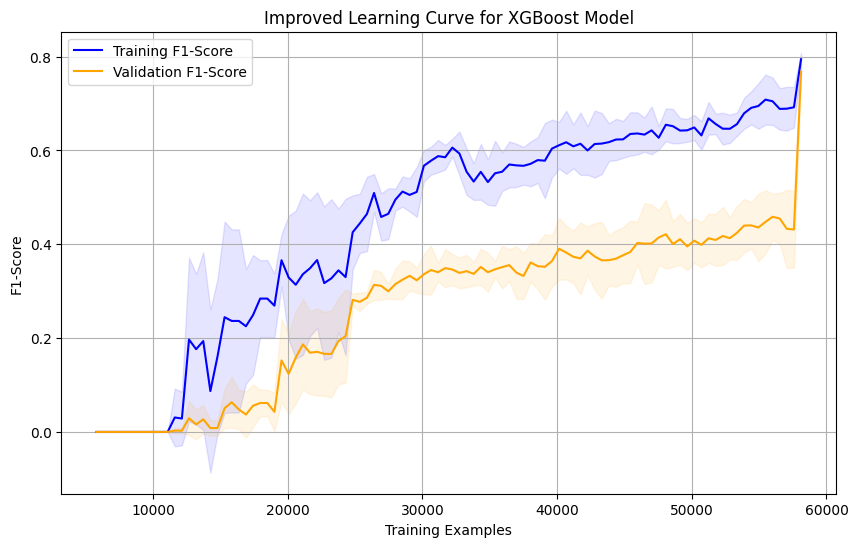


Final Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19978
           1       0.93      0.64      0.76        22

    accuracy                           1.00     20000
   macro avg       0.97      0.82      0.88     20000
weighted avg       1.00      1.00      1.00     20000

Final F1-Score (Fraud Class): 0.757


In [9]:
from sklearn.model_selection import learning_curve, StratifiedKFold
from sklearn.metrics import f1_score, classification_report, precision_recall_curve
from xgboost import XGBClassifier
import optuna  # Bayesian optimization
from sklearn.metrics import confusion_matrix

# Compute scale_pos_weight for imbalance handling
scale_pos_weight = (y_train.value_counts()[0] / y_train.value_counts()[1])

# Hyperparameter tuning with Optuna
def objective(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 3, 6),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10),  # L1 Regularization
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10),  # L2 Regularization
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'scale_pos_weight': scale_pos_weight,
        'eval_metric': 'logloss',
        'random_state': 42
    }
    
    model = XGBClassifier(**params)
    model.fit(X_train_scaled, y_train_smote)
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    return f1_score(y_test, (y_pred_proba > 0.5).astype(int))  # Default threshold

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

best_params = study.best_params
print(f"Best Parameters: {best_params}")

# Train final model with best parameters
xgb_model = XGBClassifier(**best_params)
xgb_model.fit(X_train_scaled, y_train_smote)

# Determine optimal threshold
y_pred_proba_test = xgb_model.predict_proba(X_test_scaled)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba_test)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]
print(f"Optimal Threshold from Full Training: {optimal_threshold:.3f}")

# Custom scorer using the optimal threshold
def custom_scorer(estimator, X, y):
    y_pred_proba = estimator.predict_proba(X)[:, 1]
    y_pred = (y_pred_proba >= optimal_threshold).astype(int)
    return f1_score(y, y_pred)

# Learning Curve with StratifiedKFold
train_sizes = np.linspace(0.1, 1.0, 100)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

train_sizes, train_scores, val_scores = learning_curve(
    xgb_model, X_train_scaled, y_train_smote,
    cv=cv, scoring=custom_scorer, n_jobs=-1,
    train_sizes=train_sizes
)

# Calculate mean and std
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)
val_scores_std = np.std(val_scores, axis=1)

# Plot Learning Curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Training F1-Score', color='blue')
plt.plot(train_sizes, val_scores_mean, label='Validation F1-Score', color='orange')
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color='blue')
plt.fill_between(train_sizes, val_scores_mean - val_scores_std, val_scores_mean + val_scores_std, alpha=0.1, color='orange')
plt.xlabel('Training Examples')
plt.ylabel('F1-Score')
plt.title('Improved Learning Curve for XGBoost Model')
plt.legend(loc='best')
plt.grid(True)
plt.show()

# Final Model Evaluation
y_pred_proba = xgb_model.predict_proba(X_test_scaled)[:, 1]
y_pred = (y_pred_proba >= optimal_threshold).astype(int)

print("\nFinal Classification Report:")
print(classification_report(y_test, y_pred))
print(f"Final F1-Score (Fraud Class): {f1_score(y_test, y_pred):.3f}")

# BEST

In [ ]:
from sklearn.model_selection import learning_curve, StratifiedKFold
from sklearn.metrics import f1_score, classification_report, precision_recall_curve
from xgboost import XGBClassifier
import optuna  # Bayesian optimization
from sklearn.metrics import confusion_matrix

# Compute scale_pos_weight for imbalance handling
scale_pos_weight = (y_train.value_counts()[0] / y_train.value_counts()[1])

# Hyperparameter tuning with Optuna
def objective(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 4, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'scale_pos_weight': scale_pos_weight,
        'eval_metric': 'logloss',
        'random_state': 42
    }
    
    model = XGBClassifier(**params)
    model.fit(X_train_scaled, y_train_smote)
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    return f1_score(y_test, (y_pred_proba > 0.5).astype(int))  # Default threshold

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

best_params = study.best_params
print(f"Best Parameters: {best_params}")

# Train final model with best parameters
xgb_model = XGBClassifier(**best_params)
xgb_model.fit(X_train_scaled, y_train_smote)

# Determine optimal threshold
y_pred_proba_test = xgb_model.predict_proba(X_test_scaled)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba_test)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]
print(f"Optimal Threshold from Full Training: {optimal_threshold:.3f}")

# Custom scorer using the optimal threshold
def custom_scorer(estimator, X, y):
    y_pred_proba = estimator.predict_proba(X)[:, 1]
    y_pred = (y_pred_proba >= optimal_threshold).astype(int)
    return f1_score(y, y_pred)

# Learning Curve with StratifiedKFold
train_sizes = np.linspace(0.1, 1.0, 100)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

train_sizes, train_scores, val_scores = learning_curve(
    xgb_model, X_train_scaled, y_train_smote,
    cv=cv, scoring=custom_scorer, n_jobs=-1,
    train_sizes=train_sizes
)

# Calculate mean and std
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)
val_scores_std = np.std(val_scores, axis=1)

# Plot Learning Curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Training F1-Score', color='blue')
plt.plot(train_sizes, val_scores_mean, label='Validation F1-Score', color='orange')
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color='blue')
plt.fill_between(train_sizes, val_scores_mean - val_scores_std, val_scores_mean + val_scores_std, alpha=0.1, color='orange')
plt.xlabel('Training Examples')
plt.ylabel('F1-Score')
plt.title('Improved Learning Curve for XGBoost Model')
plt.legend(loc='best')
plt.grid(True)
plt.show()

# Final Model Evaluation
y_pred_proba = xgb_model.predict_proba(X_test_scaled)[:, 1]
y_pred = (y_pred_proba >= optimal_threshold).astype(int)

print("\nFinal Classification Report:")
print(classification_report(y_test, y_pred))
print(f"Final F1-Score (Fraud Class): {f1_score(y_test, y_pred):.3f}")

-------------------------------------------

try feature engineer

In [11]:
# Feature Engineering
X_train_scaled_df['out_malicious_to_total_btc'] = X_train_scaled_df['out_malicious'] / (X_train_scaled_df['total_btc'] + 1e-6)
X_train_scaled_df['log_total_btc'] = np.log1p(X_train_scaled_df['total_btc'])
X_train_scaled_df['out_malicious_in_btc_interaction'] = X_train_scaled_df['out_malicious'] * X_train_scaled_df['in_btc']
X_train_scaled_df['net_btc_flow'] = X_train_scaled_df['in_btc'] - X_train_scaled_df['out_btc']

X_val_scaled_df['out_malicious_to_total_btc'] = X_val_scaled_df['out_malicious'] / (X_val_scaled_df['total_btc'] + 1e-6)
X_val_scaled_df['log_total_btc'] = np.log1p(X_val_scaled_df['total_btc'])
X_val_scaled_df['out_malicious_in_btc_interaction'] = X_val_scaled_df['out_malicious'] * X_val_scaled_df['in_btc']
X_val_scaled_df['net_btc_flow'] = X_val_scaled_df['in_btc'] - X_val_scaled_df['out_btc']

X_test_scaled_df['out_malicious_to_total_btc'] = X_test_scaled_df['out_malicious'] / (X_test_scaled_df['total_btc'] + 1e-6)
X_test_scaled_df['log_total_btc'] = np.log1p(X_test_scaled_df['total_btc'])
X_test_scaled_df['out_malicious_in_btc_interaction'] = X_test_scaled_df['out_malicious'] * X_test_scaled_df['in_btc']
X_test_scaled_df['net_btc_flow'] = X_test_scaled_df['in_btc'] - X_test_scaled_df['out_btc']

# Select features for training
selected_features = [
    'in_btc', 'out_btc', 'total_btc', 'out_malicious',
    'out_malicious_to_total_btc', 'log_total_btc',
    'out_malicious_in_btc_interaction', 'net_btc_flow'
]

X_train_final = X_train_scaled_df[selected_features]
X_val_final = X_val_scaled_df[selected_features]
X_test_final = X_test_scaled_df[selected_features]

# Update the XGBoost model building process
scale_pos_weight = (y_train.value_counts()[0] / y_train.value_counts()[1])

def objective(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 3, 6),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'scale_pos_weight': scale_pos_weight,
        'eval_metric': 'logloss',
        'random_state': 42
    }
    
    model = XGBClassifier(**params)
    model.fit(X_train_final, y_train_smote)
    y_pred_proba = model.predict_proba(X_val_final)[:, 1]
    return f1_score(y_val, (y_pred_proba > 0.5).astype(int))

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

best_params = study.best_params
print(f"Best Parameters: {best_params}")

# Train final model with best parameters
xgb_model = XGBClassifier(**best_params)
xgb_model.fit(X_train_final, y_train_smote)

# Evaluate the model
y_pred_proba_test = xgb_model.predict_proba(X_test_final)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba_test)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]
print(f"Optimal Threshold: {optimal_threshold:.3f}")

y_pred = (y_pred_proba_test >= optimal_threshold).astype(int)
print("\nFinal Classification Report:")
print(classification_report(y_test, y_pred))

[I 2025-03-28 16:54:10,567] A new study created in memory with name: no-name-c189f30e-d9a5-4a32-8f63-aa6851cb7834
[I 2025-03-28 16:57:34,626] Trial 0 finished with value: 0.007216959855660803 and parameters: {'max_depth': 3, 'learning_rate': 0.007880855666362848, 'n_estimators': 379, 'subsample': 0.6261644431755228, 'min_child_weight': 4, 'reg_alpha': 0.1763852774562508, 'reg_lambda': 0.0033465636283159005, 'colsample_bytree': 0.9078592655859359}. Best is trial 0 with value: 0.007216959855660803.
[I 2025-03-28 16:57:37,115] Trial 1 finished with value: 0.006235385814497272 and parameters: {'max_depth': 4, 'learning_rate': 0.004551405241546963, 'n_estimators': 342, 'subsample': 0.8806927949960752, 'min_child_weight': 6, 'reg_alpha': 0.0018900939875479952, 'reg_lambda': 0.21110338742285903, 'colsample_bytree': 0.7996890441461887}. Best is trial 0 with value: 0.007216959855660803.
[I 2025-03-28 16:57:38,203] Trial 2 finished with value: 0.001998001998001998 and parameters: {'max_depth': 5

Best Parameters: {'max_depth': 6, 'learning_rate': 0.09924117447402156, 'n_estimators': 470, 'subsample': 0.6949954632613125, 'min_child_weight': 1, 'reg_alpha': 0.028767573701347644, 'reg_lambda': 0.9473237651489378, 'colsample_bytree': 0.6858342272009632}
Optimal Threshold: 0.977

Final Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19978
           1       0.93      0.64      0.76        22

    accuracy                           1.00     20000
   macro avg       0.97      0.82      0.88     20000
weighted avg       1.00      1.00      1.00     20000

